In [1]:
from ay_torch import *
%matplotlib widget

# Testing data augmentation for CIFAR-10

In [2]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.RandomAffine(degrees=(-10, 10), scale=(1.0, 1.1)),
        #torchvision.transforms.RandomRotation(degrees=10),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 6 frog
dset_train[0][0] value range: tensor(0.) tensor(0.9608)
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 3 cat


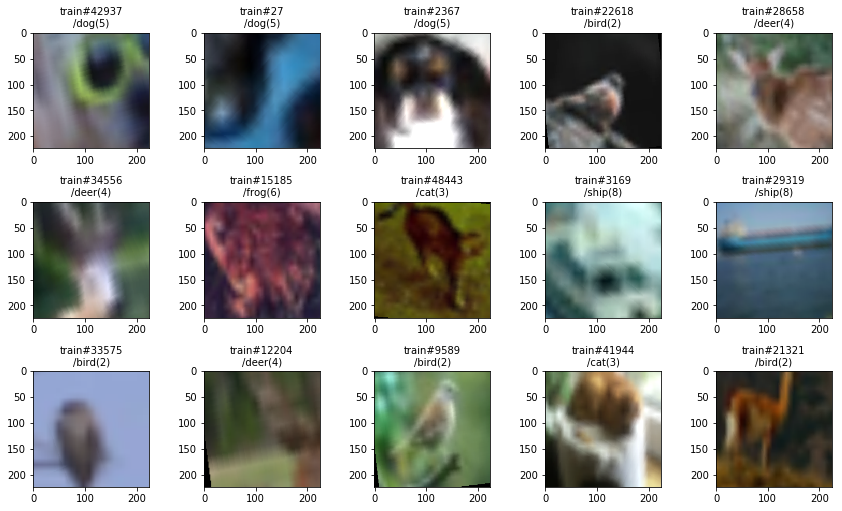

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

### TEST: Using fastai's data augmentation

The objective of this test is to know if the data augmentation of fastai contributes the learning CIFAR-10 task.

Conclusion: Yes, fastai's data augmentation increases the accuracy.

- Without my data augmentation: 89.x %
- With fastai's data augmentation: 92.5 %

In [8]:
import fastai.vision.all
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label,
                                    item_tfms=fastai.vision.all.Resize(460),
                                    batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label )
dls= dblock.dataloaders(path, bs=64)
dl_train,dl_test= dls.train, dls.valid
dset_train,dset_test= dls.train_ds, dls.valid_ds
dset_train.classes,dset_test.classes= dl_train.vocab,dl_test.vocab

## ResNet-18 with a pretrained network parameters

In [9]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

#Load pretrained model parameters.
url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [20]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 32, 32)


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

FindLR progress: 0.0%


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


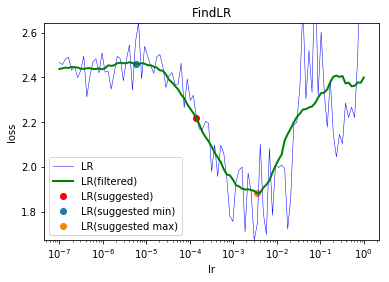

lr= 0.00014125375446227543, lr_min=5.62341325190349e-06, lr_max=0.003548133892335756


In [10]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	1.53982038	1.37955984	0.54296875	102.323878
1	0.95556760	0.86153913	0.70902593	103.071567
2	0.71727063	0.75156562	0.74858710	103.220008
3	0.55194756	0.68972171	0.78241356	103.099295
4	0.45186081	0.46443292	0.84217088	103.271035
5	0.36392842	0.34230391	0.88347739	103.194815
6	0.29064643	0.28916039	0.90109707	103.309752
7	0.22188495	0.25813864	0.91173537	102.869174
8	0.16586088	0.22924222	0.92295545	102.893137
9	0.13956922	0.22404758	0.92511636	102.924152


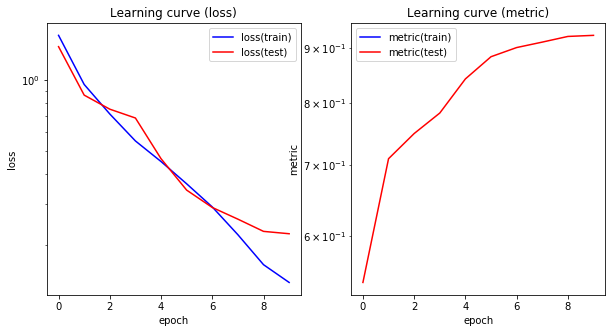

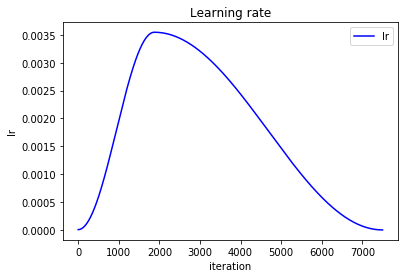

In [11]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## Tiny ResNet made with ResBlock

In [ ]:
class TResNetTiny(torch.nn.Module):
  def __init__(self, n_classes):
    super(TResNetTiny,self).__init__()
    n_layers= [3,16,32,64,128,256]
    self.net= torch.nn.Sequential(
          *[TResBlock(1, c_in, c_out, kernel_size=3) for c_in,c_out in zip(n_layers[:-1],n_layers[1:])],
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(n_layers[-1], n_classes)
          )
  def forward(self, x):
    return self.net(x)

In [ ]:
#Setup a neural network.
net= TResNetTiny(n_classes=len(dset_train.classes))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [ ]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

In [ ]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

In [ ]:
FitOneCycle(net, n_epoch=5, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)